# **Улучшение качества обучения нейросети**

1) **Загрузим датасет и модифицируем код обучения, используя различные типы LR Schedulers из Pytorch. Проведём минимум 2 эксперимента с разными шедулерами.**

In [1]:
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

In [2]:
# Задаём устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Проверка доступности CUDA (GPU)
print(torch.__version__)  # Версия PyTorch
print(torch.cuda.is_available())  # True, если GPU доступен
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))  # Имя вашего GPU
else:
    print("CUDA is not available. Please install the NVIDIA driver.")

2.4.0
True
NVIDIA GeForce RTX 3070 Laptop GPU


In [85]:
# Путь к датасету
data_dir = "C:/Users/Yaros/Downloads/archive/simpsons_dataset"

# Преобразования (аугментации) для тренировочных и валидационных данных
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
# Загрузка тренировочных и валидационных данных
train_data = datasets.ImageFolder(os.path.join(data_dir), transform=train_transforms)
val_data = datasets.ImageFolder(os.path.join(data_dir), transform=val_transforms)

# DataLoader для загрузки данных
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

In [6]:
from torchvision.models import ResNet18_Weights

# Модель ResNet18 с предобученными весами
weights = ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)

# Замораживаем все слои, кроме последнего
for param in model.parameters():
    param.requires_grad = False

# Заменяем последний слой (fc) для соответствия количеству классов
num_classes = len(train_data.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Кросс-энтропийная функция потерь и Adam оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [7]:
# Функция для тренировки и валидации
def train_model(model, criterion, optimizer, scheduler, num_epochs=5, use_plateau=False):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'lr': []
    }
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        # Тренировочная фаза
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        # Валидационная фаза
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())

        # Сохраняем learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)

        # Шаг шедулера
        if use_plateau:
            scheduler.step(val_loss)  # Для ReduceLROnPlateau нужно передавать метрику
        else:
            scheduler.step()

    return model, history

- *Эксперимент 1: Используем StepLR*

In [8]:
# StepLR - уменьшаем learning rate каждые 7 эпох на фактор 0.1
scheduler_steplr = StepLR(optimizer, step_size=7, gamma=0.1)

# Тренировка модели
print("Experiment 1: StepLR")
trained_model_steplr, history_steplr = train_model(model, criterion, optimizer, scheduler_steplr, num_epochs=10)

Experiment 1: StepLR
Epoch 1/10
----------
Train Loss: 1.6174 Acc: 0.4895
Val Loss: 1.3656 Acc: 0.4880
Epoch 2/10
----------
Train Loss: 1.3714 Acc: 0.4866
Val Loss: 1.3239 Acc: 0.4867
Epoch 3/10
----------
Train Loss: 1.3214 Acc: 0.4849
Val Loss: 1.2502 Acc: 0.4982
Epoch 4/10
----------
Train Loss: 1.3032 Acc: 0.4819
Val Loss: 1.2317 Acc: 0.4959
Epoch 5/10
----------
Train Loss: 1.2880 Acc: 0.4842
Val Loss: 1.2494 Acc: 0.4869
Epoch 6/10
----------
Train Loss: 1.2781 Acc: 0.4802
Val Loss: 1.2203 Acc: 0.4933
Epoch 7/10
----------
Train Loss: 1.2651 Acc: 0.4828
Val Loss: 1.2137 Acc: 0.4915
Epoch 8/10
----------
Train Loss: 1.1821 Acc: 0.4940
Val Loss: 1.1553 Acc: 0.4942
Epoch 9/10
----------
Train Loss: 1.1722 Acc: 0.4939
Val Loss: 1.1436 Acc: 0.4968
Epoch 10/10
----------
Train Loss: 1.1671 Acc: 0.4981
Val Loss: 1.1419 Acc: 0.4961


- *Эксперимент 2: Используем ReduceLROnPlateau*

In [10]:
# ReduceLROnPlateau - уменьшаем learning rate, если валидирующая ошибка не уменьшается
scheduler_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Тренировка модели с ReduceLROnPlateau
print("Experiment 2: ReduceLROnPlateau")
trained_model_plateau, history_plateau = train_model(model, criterion, optimizer, scheduler_plateau, num_epochs=10, use_plateau=True)

Experiment 2: ReduceLROnPlateau
Epoch 1/10
----------
Train Loss: 1.1669 Acc: 0.4922
Val Loss: 1.1407 Acc: 0.4960
Epoch 2/10
----------
Train Loss: 1.1664 Acc: 0.4956
Val Loss: 1.1413 Acc: 0.4964
Epoch 3/10
----------
Train Loss: 1.1674 Acc: 0.4941
Val Loss: 1.1402 Acc: 0.4961
Epoch 4/10
----------
Train Loss: 1.1679 Acc: 0.4947
Val Loss: 1.1426 Acc: 0.4959
Epoch 5/10
----------
Train Loss: 1.1657 Acc: 0.4944
Val Loss: 1.1507 Acc: 0.4951
Epoch 6/10
----------
Train Loss: 1.1635 Acc: 0.4959
Val Loss: 1.1475 Acc: 0.4951
Epoch 7/10
----------
Train Loss: 1.1604 Acc: 0.4959
Val Loss: 1.1369 Acc: 0.4968
Epoch 8/10
----------
Train Loss: 1.1606 Acc: 0.4948
Val Loss: 1.1407 Acc: 0.4955
Epoch 9/10
----------
Train Loss: 1.1601 Acc: 0.4942
Val Loss: 1.1335 Acc: 0.4963
Epoch 10/10
----------
Train Loss: 1.1613 Acc: 0.4914
Val Loss: 1.1369 Acc: 0.4967


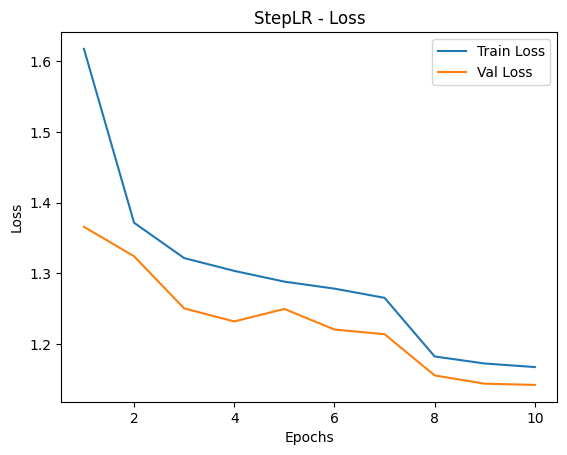

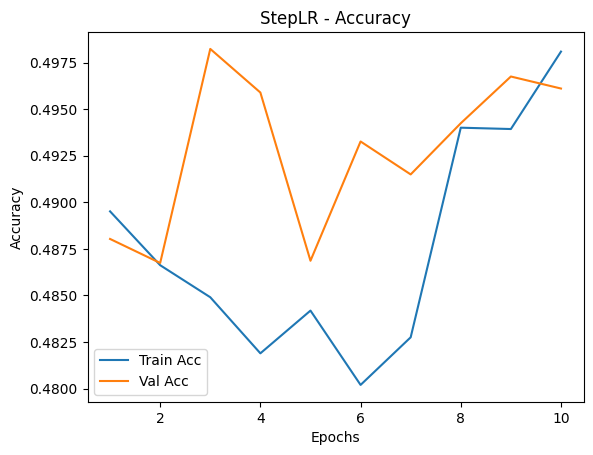

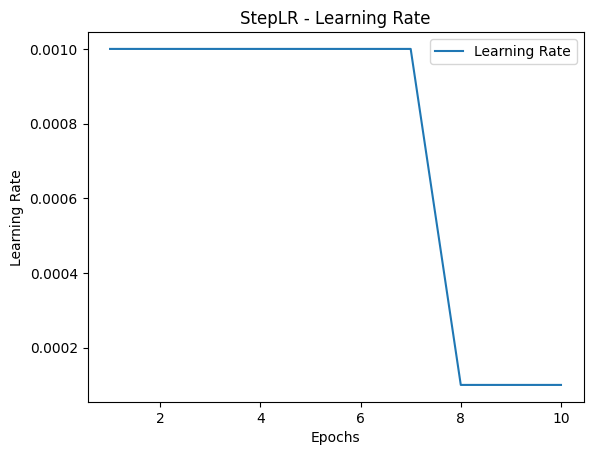

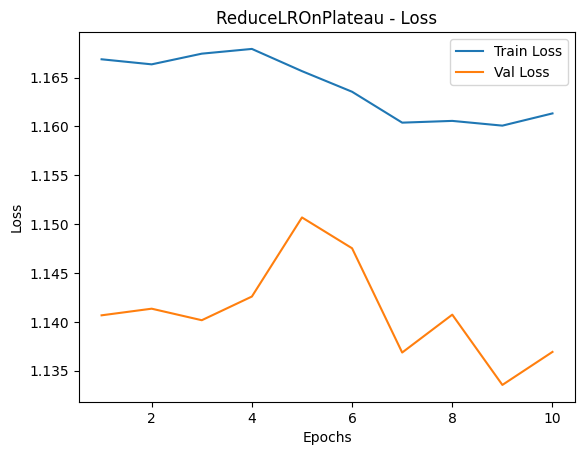

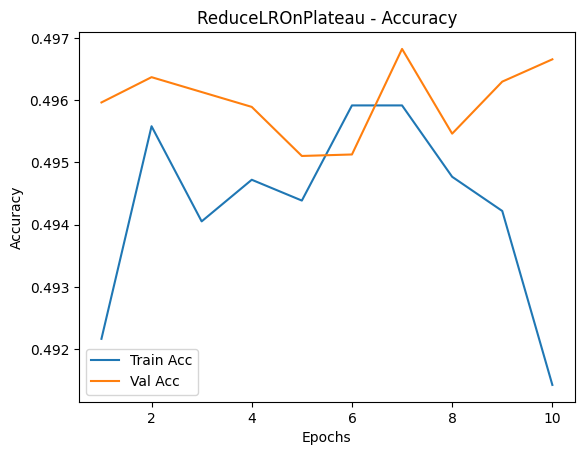

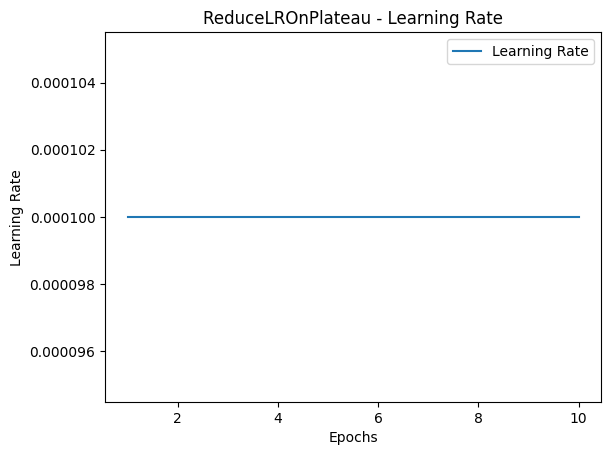

In [12]:
import matplotlib.pyplot as plt

def plot_results(history, title):
    epochs = range(1, len(history['train_loss']) + 1)

    # График потерь
    plt.figure()
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # График точности
    plt.figure()
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # График изменения learning rate
    plt.figure()
    plt.plot(epochs, history['lr'], label='Learning Rate')
    plt.title(f'{title} - Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()

# Построение графиков для каждого эксперимента
plot_results(history_steplr, "StepLR")
plot_results(history_plateau, "ReduceLROnPlateau")


2) **Подберём аугментации train данных, при которых итоговое качество на валидации станет сильно хуже, чем [полученное на занятии](https://github.com/netology-ds-team/DLL/blob/main/DLL-materials/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5%205.%20%D0%A3%D0%BB%D1%83%D1%87%D1%88%D0%B5%D0%BD%D0%B8%D0%B5%20%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0%20%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B5%D0%B9.ipynb).**

In [32]:
# Аугментации для ухудшения качества данных
aggressive_train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(90),  # Случайные повороты до 90 градусов
    transforms.GaussianBlur(5),     # Добавляем размытие с радиусом ядра 5
    transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.5),  # Сильные изменения яркости и контраста
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [33]:
# Загрузка тренировочных данных с новыми аугментациями
train_data_aggressive = datasets.ImageFolder(os.path.join(data_dir), transform=aggressive_train_transforms)
train_loader_aggressive = DataLoader(train_data_aggressive, batch_size=32, shuffle=True)
train_loader = train_loader_aggressive

In [34]:
# Обучение модели с агрессивными аугментациями
print("Training with aggressive augmentations")
trained_model_aggressive, history_aggressive = train_model(model, criterion, optimizer, scheduler_steplr, num_epochs=10)

Training with aggressive augmentations
Epoch 1/10
----------
Train Loss: 2.3786 Acc: 0.4911
Val Loss: 1.6989 Acc: 0.4921
Epoch 2/10
----------
Train Loss: 2.3749 Acc: 0.4892
Val Loss: 1.7114 Acc: 0.4925
Epoch 3/10
----------
Train Loss: 2.3802 Acc: 0.4908
Val Loss: 1.7035 Acc: 0.4931
Epoch 4/10
----------
Train Loss: 2.3802 Acc: 0.4919
Val Loss: 1.7243 Acc: 0.4928
Epoch 5/10
----------
Train Loss: 2.3713 Acc: 0.4901
Val Loss: 1.7066 Acc: 0.4929
Epoch 6/10
----------
Train Loss: 2.3843 Acc: 0.4898
Val Loss: 1.7139 Acc: 0.4922
Epoch 7/10
----------
Train Loss: 2.3692 Acc: 0.4924
Val Loss: 1.6930 Acc: 0.4932
Epoch 8/10
----------
Train Loss: 2.3847 Acc: 0.4902
Val Loss: 1.7370 Acc: 0.4921
Epoch 9/10
----------
Train Loss: 2.3799 Acc: 0.4907
Val Loss: 1.6914 Acc: 0.4917
Epoch 10/10
----------
Train Loss: 2.3850 Acc: 0.4911
Val Loss: 1.7213 Acc: 0.4919


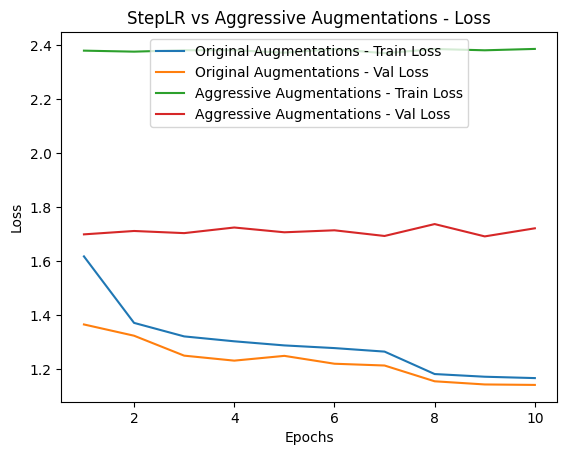

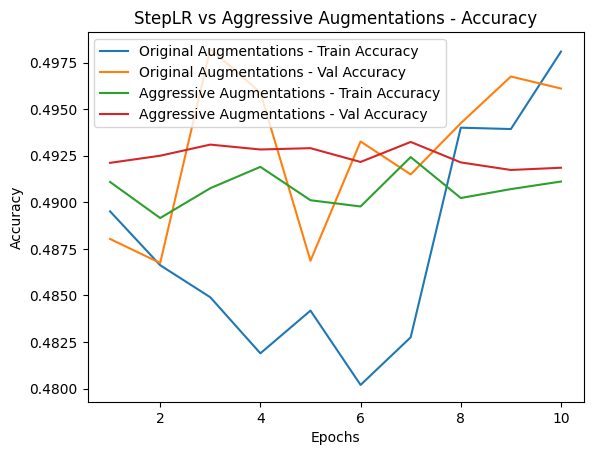

In [35]:
# Функция для сравнения двух историй обучения
def plot_comparison(history1, history2, label1, label2, title):
    epochs = range(1, len(history1['train_loss']) + 1)

    # График потерь
    plt.figure()
    plt.plot(epochs, history1['train_loss'], label=f'{label1} - Train Loss')
    plt.plot(epochs, history1['val_loss'], label=f'{label1} - Val Loss')
    plt.plot(epochs, history2['train_loss'], label=f'{label2} - Train Loss')
    plt.plot(epochs, history2['val_loss'], label=f'{label2} - Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # График точности
    plt.figure()
    plt.plot(epochs, history1['train_acc'], label=f'{label1} - Train Accuracy')
    plt.plot(epochs, history1['val_acc'], label=f'{label1} - Val Accuracy')
    plt.plot(epochs, history2['train_acc'], label=f'{label2} - Train Accuracy')
    plt.plot(epochs, history2['val_acc'], label=f'{label2} - Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Сравниваем результаты с базовыми аугментациями и агрессивными аугментациями
plot_comparison(history_steplr, history_aggressive, 'Original Augmentations', 'Aggressive Augmentations', 'StepLR vs Aggressive Augmentations')

Попытка №2 С использованием менее устойчивой архитектуры

In [37]:
from torchvision.models import vgg16, VGG16_Weights

# Используем VGG16 с предобученными весами
weights = VGG16_Weights.DEFAULT
model_vgg16 = vgg16(weights=weights)

# Замораживаем все слои, кроме последнего
for param in model_vgg16.parameters():
    param.requires_grad = False

# Заменяем последний слой для VGG16, чтобы он соответствовал количеству классов в нашем наборе данных
model_vgg16.classifier[6] = nn.Linear(model_vgg16.classifier[6].in_features, num_classes)
model_vgg16 = model_vgg16.to(device)

# Оптимизатор
optimizer_vgg16 = optim.Adam(model_vgg16.classifier.parameters(), lr=0.001)

# Аугментации для ухудшения качества данных (пример агрессивных аугментаций)
aggressive_train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(90),  # Повороты до 90 градусов
    transforms.GaussianBlur(kernel_size=(7, 7)),  # Размытие
    transforms.ColorJitter(brightness=1.0, contrast=1.0, saturation=1.0, hue=0.5),  # Максимальные цветовые изменения
    transforms.RandomPerspective(distortion_scale=0.6, p=0.8),  # Искажение перспективы
    transforms.RandomAffine(degrees=45, translate=(0.2, 0.2)),  # Сильные сдвиги
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.RandomErasing(p=0.8, scale=(0.02, 0.4), ratio=(0.1, 2.0), value='random'),  # Удаление частей изображения
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Нормализация
])

# Загрузка тренировочных данных с агрессивными аугментациями
train_data_aggressive = datasets.ImageFolder(os.path.join(data_dir), transform=aggressive_train_transforms)
train_loader_aggressive = DataLoader(train_data_aggressive, batch_size=32, shuffle=True)
train_loader = train_loader_aggressive

# Обучение модели VGG16 с агрессивными аугментациями
print("Training VGG16 with aggressive augmentations")
trained_model_vgg16_aggressive, history_vgg16_aggressive = train_model(model_vgg16, criterion, optimizer_vgg16, scheduler_steplr, num_epochs=10)

Training VGG16 with aggressive augmentations
Epoch 1/10
----------
Train Loss: 2.7184 Acc: 0.4522
Val Loss: 2.8165 Acc: 0.4915
Epoch 2/10
----------
Train Loss: 2.8068 Acc: 0.4355
Val Loss: 2.7782 Acc: 0.4949
Epoch 3/10
----------
Train Loss: 2.8443 Acc: 0.4298
Val Loss: 2.7474 Acc: 0.4778
Epoch 4/10
----------
Train Loss: 2.8510 Acc: 0.4284
Val Loss: 2.8258 Acc: 0.4860
Epoch 5/10
----------
Train Loss: 2.8619 Acc: 0.4290
Val Loss: 2.8246 Acc: 0.4888
Epoch 6/10
----------
Train Loss: 2.8568 Acc: 0.4284
Val Loss: 2.8955 Acc: 0.4966
Epoch 7/10
----------
Train Loss: 2.8773 Acc: 0.4254
Val Loss: 2.7620 Acc: 0.3939
Epoch 8/10
----------
Train Loss: 2.8710 Acc: 0.4302
Val Loss: 2.8799 Acc: 0.4085
Epoch 9/10
----------
Train Loss: 2.8760 Acc: 0.4260
Val Loss: 2.8012 Acc: 0.4881
Epoch 10/10
----------
Train Loss: 2.8820 Acc: 0.4261
Val Loss: 2.8145 Acc: 0.4679


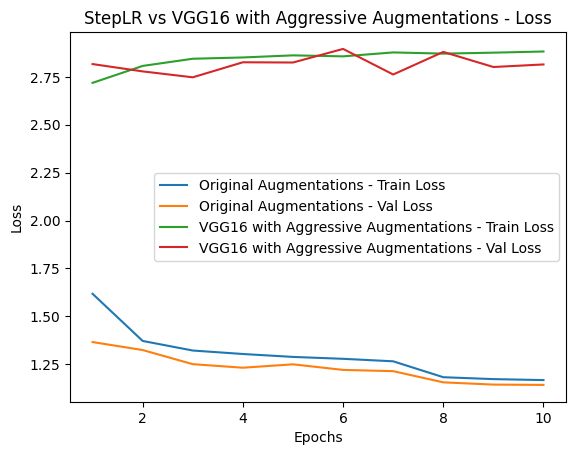

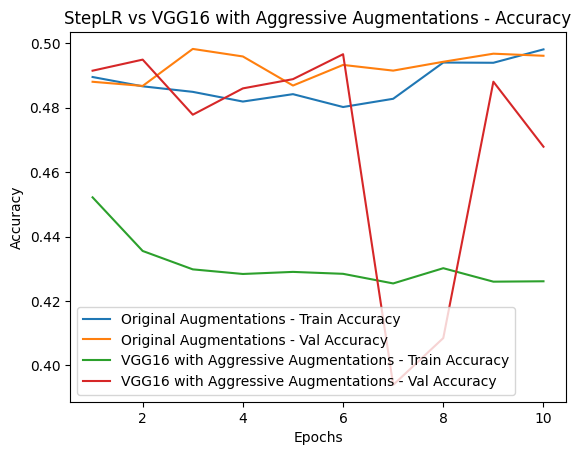

In [38]:
# Сравнение
plot_comparison(history_steplr, history_vgg16_aggressive, 'Original Augmentations', 'VGG16 with Aggressive Augmentations', 'StepLR vs VGG16 with Aggressive Augmentations')

Попытка №3 подберём ещё более агрессивные аугментации с добавление шума, уменьшения разрешения и изменением аугментации валидационного набора.

In [42]:
from torchvision.transforms import RandomAffine, RandomErasing
import numpy as np
import torch

# Добавление шума
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

# Агрессивные аугментации для тренировочных данных
aggressive_train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(90),  # Повороты до 90 градусов
    transforms.GaussianBlur(kernel_size=(5, 5)),  # Размытие
    transforms.ColorJitter(brightness=1.5, contrast=1.5, saturation=1.5, hue=0.5),  # Сильные изменения цвета
    transforms.RandomPerspective(distortion_scale=0.6, p=0.8),  # Искажение перспективы
    transforms.RandomAffine(degrees=45, translate=(0.3, 0.3)),  # Сдвиги
    transforms.ToTensor(),  # Преобразование изображения в тензор
    AddGaussianNoise(0., 0.2),  # Добавление шума после преобразования в тензор
    transforms.RandomErasing(p=0.8, scale=(0.02, 0.4), ratio=(0.3, 3.0), value='random'),  # Удаление части изображения
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Нормализация
])

# Аугментации для валидационных данных (менее агрессивные)
val_transforms_aggressive = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.GaussianBlur(kernel_size=(5, 5)),  # Лёгкое размытие для валидации
    transforms.ColorJitter(brightness=1.5, contrast=1.5, saturation=1.5, hue=0.5),  # Сильные изменения цвета
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Загрузка тренировочных данных с агрессивными аугментациями
train_data_aggressive = datasets.ImageFolder(os.path.join(data_dir), transform=aggressive_train_transforms)
train_loader_aggressive = DataLoader(train_data_aggressive, batch_size=32, shuffle=True)

# Загрузка валидационных данных с агрессивными аугментациями
val_data_aggressive = datasets.ImageFolder(os.path.join(data_dir), transform=val_transforms_aggressive)
val_loader_aggressive = DataLoader(val_data_aggressive, batch_size=32, shuffle=False)

In [ ]:
# Функция для обучения модели
def train_model_dynamic(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=10, use_plateau=False):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'lr': []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        # Тренировочная фаза
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        # Валидационная фаза
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss}, Train Acc: {train_acc}, LR: {scheduler.get_last_lr()}")
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())

        # Сохраняем learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)

        # Шаг шедулера
        if use_plateau:
            scheduler.step(val_loss)  # Для ReduceLROnPlateau нужно передавать метрику
        else:
            scheduler.step()

    return model, history

In [44]:
# Теперь мы можем обучить модель, используя агрессивные аугментации и корректно применяя train_loader и val_loader
print("Training VGG16 with aggressive augmentations and normal dataset")
trained_model_vgg16_aggressive, history_vgg16_aggressive = train_model_dynamic(model_vgg16, criterion, optimizer_vgg16, scheduler_steplr, train_loader_aggressive, val_loader_aggressive, num_epochs=10)

Training VGG16 with aggressive augmentations and normal dataset
Epoch 1/10
----------
Train Loss: 2.9105 Acc: 0.4308
Val Loss: 2.6944 Acc: 0.4761
Epoch 2/10
----------
Train Loss: 2.8492 Acc: 0.4377
Val Loss: 2.7990 Acc: 0.4746
Epoch 3/10
----------
Train Loss: 2.8406 Acc: 0.4396
Val Loss: 2.8463 Acc: 0.4939
Epoch 4/10
----------
Train Loss: 2.8357 Acc: 0.4386
Val Loss: 2.8411 Acc: 0.4971
Epoch 5/10
----------
Train Loss: 2.8381 Acc: 0.4400
Val Loss: 2.8424 Acc: 0.4740
Epoch 6/10
----------
Train Loss: 2.8348 Acc: 0.4382
Val Loss: 3.0029 Acc: 0.4400
Epoch 7/10
----------
Train Loss: 2.8364 Acc: 0.4399
Val Loss: 2.9929 Acc: 0.4948
Epoch 8/10
----------
Train Loss: 2.8489 Acc: 0.4370
Val Loss: 3.3297 Acc: 0.4962
Epoch 9/10
----------
Train Loss: 2.8317 Acc: 0.4387
Val Loss: 3.1096 Acc: 0.4861
Epoch 10/10
----------
Train Loss: 2.8302 Acc: 0.4393
Val Loss: 3.1764 Acc: 0.4853


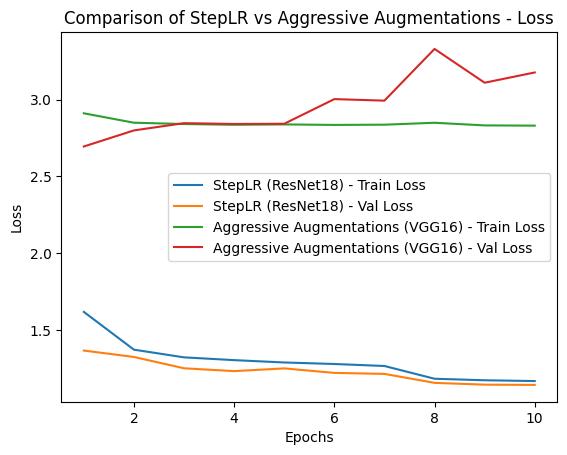

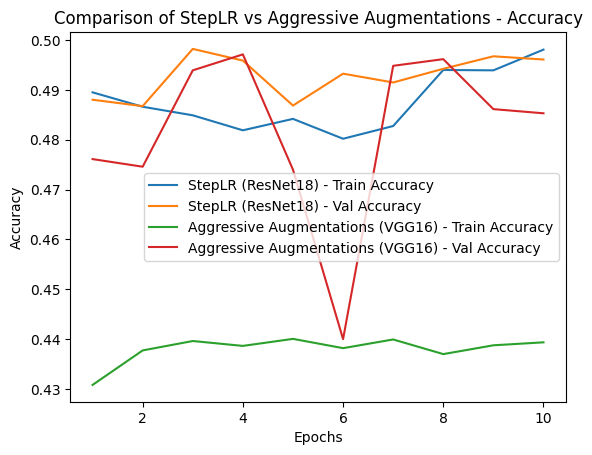

In [46]:
# Сравнение результатов для StepLR и агрессивных аугментаций на VGG16
plot_comparison(history_steplr, history_vgg16_aggressive, 'StepLR (ResNet18)', 'Aggressive Augmentations (VGG16)', 'Comparison of StepLR vs Aggressive Augmentations')

3) **Возьмём любую архитектуру (VGG, EfficientNet или MobileNet) и примените к ней методы, которые разбирались [на занятии](https://github.com/netology-ds-team/DLL/blob/main/DLL-materials/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5%205.%20%D0%A3%D0%BB%D1%83%D1%87%D1%88%D0%B5%D0%BD%D0%B8%D0%B5%20%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0%20%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B5%D0%B9.ipynb).**

In [62]:
import torch
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Аугментации для обучения
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Загрузка данных
data_dir = "C:/Users/Yaros/Downloads/archive/simpsons_dataset"  # Проверьте путь
train_data = datasets.ImageFolder(os.path.join(data_dir), transform=train_transforms)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

val_data = datasets.ImageFolder(os.path.join(data_dir), transform=val_transforms)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# MobileNetV2 с предобученными весами
weights = MobileNet_V2_Weights.DEFAULT
model_mobilenet = mobilenet_v2(weights=weights)

# Feature Extraction: Замораживаем все слои, кроме классификатора
for param in model_mobilenet.parameters():
    param.requires_grad = False

# Заменяем последний слой для соответствия количеству классов
num_classes = len(train_data.classes)
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.classifier[1].in_features, num_classes)
model_mobilenet = model_mobilenet.to(device)

# Критерий и оптимизатор для классификатора
criterion = nn.CrossEntropyLoss()
optimizer_mobilenet = optim.SGD(model_mobilenet.classifier.parameters(), lr=0.01)
scheduler_steplr_mobilenet = StepLR(optimizer_mobilenet, step_size=7, gamma=0.1)

# Использование MobileNetV2 как Feature Extractor
trained_model_mobilenet_fe, history_fe = train_model_dynamic(
    model_mobilenet, criterion, optimizer_mobilenet, scheduler_steplr_mobilenet, 
    train_loader, val_loader, num_epochs=10
)

Epoch 1/10
----------
Train Loss: 2.1599 Acc: 0.4989
Val Loss: 1.9859 Acc: 0.5000
Epoch 2/10
----------
Train Loss: 1.8790 Acc: 0.4994
Val Loss: 1.7968 Acc: 0.4999
Epoch 3/10
----------
Train Loss: 1.7429 Acc: 0.4991
Val Loss: 1.7050 Acc: 0.4995
Epoch 4/10
----------
Train Loss: 1.6604 Acc: 0.4994
Val Loss: 1.6217 Acc: 0.4990
Epoch 5/10
----------
Train Loss: 1.6068 Acc: 0.4983
Val Loss: 1.5738 Acc: 0.4988
Epoch 6/10
----------
Train Loss: 1.5726 Acc: 0.4968
Val Loss: 1.5491 Acc: 0.4989
Epoch 7/10
----------
Train Loss: 1.5393 Acc: 0.4952
Val Loss: 1.5022 Acc: 0.4985
Epoch 8/10
----------
Train Loss: 1.5244 Acc: 0.4991
Val Loss: 1.5151 Acc: 0.4985
Epoch 9/10
----------
Train Loss: 1.5214 Acc: 0.4973
Val Loss: 1.5072 Acc: 0.4987
Epoch 10/10
----------
Train Loss: 1.5147 Acc: 0.4977
Val Loss: 1.5210 Acc: 0.4984


In [99]:
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

# 1. Задание устройства для вычислений
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Задание путей и параметров
data_dir = "C:/Users/Yaros/Downloads/archive/simpsons_dataset"
batch_size = 32
num_epochs = 10
val_percentage = 0.2

Using device: cuda


In [100]:
# 3. Преобразования данных (аугментации)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# 4. Загрузка и разделение данных
full_dataset = datasets.ImageFolder(os.path.join(data_dir))
num_classes = len(full_dataset.classes)
print(f"Number of classes: {num_classes}")

val_size = int(len(full_dataset) * val_percentage)
train_size = len(full_dataset) - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Training data size: {len(train_dataset)}")
print(f"Validation data size: {len(val_dataset)}")

Number of classes: 43
Training data size: 33493
Validation data size: 8373


In [101]:
# 5. Применение трансформаций к наборам данных
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __getitem__(self, index):
        image, label = self.dataset[index]
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.dataset)

train_dataset = CustomDataset(train_dataset, transform=train_transforms)
val_dataset = CustomDataset(val_dataset, transform=val_transforms)

# 6. Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [102]:
# 7. Определение функции обучения модели
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'lr': []
    }
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        # Тренировочная фаза
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward
            loss.backward()
            optimizer.step()

            # Статистика
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Средние значения потерь и точности
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        # Валидационная фаза
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())

        # Шаг шедулера
        scheduler.step()

    return model, history

In [103]:
# 8. Часть 1: Feature Extraction
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

weights = MobileNet_V2_Weights.DEFAULT
model = mobilenet_v2(weights=weights)

# Замораживаем все параметры
for param in model.parameters():
    param.requires_grad = False

# Заменяем классификатор
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Обучение модели
print("Feature Extraction - Training MobileNetV2")
model_fe, history_fe = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)

Feature Extraction - Training MobileNetV2
Epoch 1/10
----------
Train Loss: 2.2106 Acc: 0.4955
Val Loss: 2.0543 Acc: 0.5014
Epoch 2/10
----------
Train Loss: 1.9331 Acc: 0.4997
Val Loss: 1.8852 Acc: 0.5003
Epoch 3/10
----------
Train Loss: 1.7970 Acc: 0.4990
Val Loss: 1.7834 Acc: 0.4997
Epoch 4/10
----------
Train Loss: 1.7070 Acc: 0.5000
Val Loss: 1.7077 Acc: 0.5002
Epoch 5/10
----------
Train Loss: 1.6501 Acc: 0.4989
Val Loss: 1.6608 Acc: 0.5001
Epoch 6/10
----------
Train Loss: 1.6181 Acc: 0.5009
Val Loss: 1.6629 Acc: 0.4999
Epoch 7/10
----------
Train Loss: 1.6190 Acc: 0.4972
Val Loss: 1.6465 Acc: 0.4985
Epoch 8/10
----------
Train Loss: 1.6108 Acc: 0.5003
Val Loss: 1.6500 Acc: 0.4965
Epoch 9/10
----------
Train Loss: 1.6099 Acc: 0.5002
Val Loss: 1.6341 Acc: 0.4978
Epoch 10/10
----------
Train Loss: 1.6041 Acc: 0.4990
Val Loss: 1.6385 Acc: 0.4983


In [104]:
# 9. Часть 2: Fine-Tuning
# Размораживаем некоторые слои
for name, param in model.named_parameters():
    if "features.14" in name or "features.13" in name:
        param.requires_grad = True

# Оптимизатор для Fine-Tuning
optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, momentum=0.9)
scheduler_ft = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

# Обучение модели с Fine-Tuning
print("Fine-Tuning MobileNetV2")
model_ft, history_ft = train_model(model, criterion, optimizer_ft, scheduler_ft, num_epochs=num_epochs)

Fine-Tuning MobileNetV2
Epoch 1/10
----------
Train Loss: 1.5849 Acc: 0.4976
Val Loss: 1.5881 Acc: 0.4964
Epoch 2/10
----------
Train Loss: 1.5487 Acc: 0.4974
Val Loss: 1.5521 Acc: 0.4929
Epoch 3/10
----------
Train Loss: 1.5152 Acc: 0.4979
Val Loss: 1.5235 Acc: 0.4910
Epoch 4/10
----------
Train Loss: 1.4904 Acc: 0.5017
Val Loss: 1.4978 Acc: 0.4912
Epoch 5/10
----------
Train Loss: 1.4673 Acc: 0.4988
Val Loss: 1.4667 Acc: 0.4913
Epoch 6/10
----------
Train Loss: 1.4537 Acc: 0.5011
Val Loss: 1.4689 Acc: 0.4941
Epoch 7/10
----------
Train Loss: 1.4493 Acc: 0.5031
Val Loss: 1.4636 Acc: 0.4911
Epoch 8/10
----------
Train Loss: 1.4507 Acc: 0.4991
Val Loss: 1.4681 Acc: 0.4901
Epoch 9/10
----------
Train Loss: 1.4472 Acc: 0.5022
Val Loss: 1.4614 Acc: 0.4925
Epoch 10/10
----------
Train Loss: 1.4452 Acc: 0.4995
Val Loss: 1.4538 Acc: 0.4918


Попытка 3

In [105]:
# Загружаем полный набор данных с трансформациями для тренировочных данных
full_dataset = datasets.ImageFolder(os.path.join(data_dir), transform=train_transforms)

In [109]:
from sklearn.model_selection import train_test_split

# Получаем все индексы данных
dataset_size = len(full_dataset)
indices = list(range(dataset_size))

# Разделяем индексы на тренировочные и валидационные
train_indices, val_indices = train_test_split(indices, test_size=val_percentage, random_state=42)

In [110]:
from torch.utils.data.sampler import SubsetRandomSampler

# Создаем самплеры
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)


In [112]:
from torch.utils.data import DataLoader

# DataLoader для тренировочных данных
train_loader = DataLoader(full_dataset, batch_size=batch_size, sampler=train_sampler)

# DataLoader для валидационных данных (используем другие трансформации)
full_dataset_val = datasets.ImageFolder(os.path.join(data_dir), transform=val_transforms)
val_loader = DataLoader(full_dataset_val, batch_size=batch_size, sampler=val_sampler)

#Важно: Мы используем один и тот же ImageFolder, чтобы гарантировать, что class_to_idx и метки классов совпадают между тренировочным и валидационным наборами данных.

In [113]:
# Проверяем метки в тренировочном наборе
for inputs, labels in train_loader:
    print("Train labels:", labels)
    break

# Проверяем метки в валидационном наборе
for inputs, labels in val_loader:
    print("Validation labels:", labels)
    break

Train labels: tensor([ 6, 32, 25, 39,  4, 39, 39, 39, 39, 39, 39, 27, 28, 20,  2, 39,  7, 20,
        39, 39, 39, 39, 39, 39, 32, 39, 11, 22, 15, 39, 39, 39])
Validation labels: tensor([39, 25, 20, 39, 39, 15, 32, 39, 39, 15, 39,  6, 39, 39, 39, 39,  6, 39,
        39, 39,  4, 39, 39, 39,  0, 18, 39,  9, 18, 39, 39, 15])


In [115]:
# Используем предобученную модель MobileNetV2
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

weights = MobileNet_V2_Weights.DEFAULT
model = mobilenet_v2(weights=weights)

# Замораживаем все параметры для Feature Extraction
for param in model.parameters():
    param.requires_grad = False

# Заменяем классификатор
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Обучение модели
print("Feature Extraction - Training MobileNetV2")
model_fe, history_fe = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)

Feature Extraction - Training MobileNetV2
Epoch 1/10
----------
Train Loss: 1.7693 Acc: 0.3983
Val Loss: 0.4130 Acc: 0.0990
Epoch 2/10
----------
Train Loss: 1.5457 Acc: 0.4011
Val Loss: 0.3792 Acc: 0.0990
Epoch 3/10
----------
Train Loss: 1.4374 Acc: 0.3996
Val Loss: 0.3551 Acc: 0.0992
Epoch 4/10
----------
Train Loss: 1.3698 Acc: 0.4004
Val Loss: 0.3416 Acc: 0.0989
Epoch 5/10
----------
Train Loss: 1.3189 Acc: 0.4013
Val Loss: 0.3323 Acc: 0.0988
Epoch 6/10
----------
Train Loss: 1.2963 Acc: 0.4018
Val Loss: 0.3288 Acc: 0.0988
Epoch 7/10
----------
Train Loss: 1.2926 Acc: 0.4009
Val Loss: 0.3315 Acc: 0.0988
Epoch 8/10
----------
Train Loss: 1.2902 Acc: 0.3996
Val Loss: 0.3279 Acc: 0.0991
Epoch 9/10
----------
Train Loss: 1.2871 Acc: 0.4002
Val Loss: 0.3293 Acc: 0.0988
Epoch 10/10
----------
Train Loss: 1.2852 Acc: 0.4004
Val Loss: 0.3286 Acc: 0.0989


Попытка 4

In [116]:
from torchvision import datasets, transforms

# Загружаем полный набор данных без трансформаций
full_dataset = datasets.ImageFolder(os.path.join(data_dir))


In [117]:
from sklearn.model_selection import train_test_split

# Получаем все индексы
dataset_size = len(full_dataset)
indices = list(range(dataset_size))

# Разделяем индексы
train_indices, val_indices = train_test_split(indices, test_size=val_percentage, random_state=42)


In [118]:
class SubsetWithTransform(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        image, label = self.dataset[actual_idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.indices)


In [119]:
# Преобразования для тренировочных данных
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Преобразования для валидационных данных
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Создаем подмножества с трансформациями
train_dataset = SubsetWithTransform(full_dataset, train_indices, transform=train_transforms)
val_dataset = SubsetWithTransform(full_dataset, val_indices, transform=val_transforms)


In [120]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [121]:
# Проверяем class_to_idx
print("Class to index mapping:", full_dataset.class_to_idx)

# Проверяем первые несколько меток в тренировочном наборе
for _, label in train_loader:
    print("Train labels:", label[:10])
    break

# Проверяем первые несколько меток в валидационном наборе
for _, label in val_loader:
    print("Validation labels:", label[:10])
    break


Class to index mapping: {'abraham_grampa_simpson': 0, 'agnes_skinner': 1, 'apu_nahasapeemapetilon': 2, 'barney_gumble': 3, 'bart_simpson': 4, 'carl_carlson': 5, 'charles_montgomery_burns': 6, 'chief_wiggum': 7, 'cletus_spuckler': 8, 'comic_book_guy': 9, 'disco_stu': 10, 'edna_krabappel': 11, 'fat_tony': 12, 'gil': 13, 'groundskeeper_willie': 14, 'homer_simpson': 15, 'kent_brockman': 16, 'krusty_the_clown': 17, 'lenny_leonard': 18, 'lionel_hutz': 19, 'lisa_simpson': 20, 'maggie_simpson': 21, 'marge_simpson': 22, 'martin_prince': 23, 'mayor_quimby': 24, 'milhouse_van_houten': 25, 'miss_hoover': 26, 'moe_szyslak': 27, 'ned_flanders': 28, 'nelson_muntz': 29, 'otto_mann': 30, 'patty_bouvier': 31, 'principal_skinner': 32, 'professor_john_frink': 33, 'rainier_wolfcastle': 34, 'ralph_wiggum': 35, 'selma_bouvier': 36, 'sideshow_bob': 37, 'sideshow_mel': 38, 'simpsons_dataset': 39, 'snake_jailbird': 40, 'troy_mcclure': 41, 'waylon_smithers': 42}
Train labels: tensor([29, 39, 39, 39, 39, 11, 27, 

In [122]:
import torch
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torch import nn, optim

# Задаем устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загружаем предобученную модель
weights = MobileNet_V2_Weights.DEFAULT
model = mobilenet_v2(weights=weights)

# Замораживаем все параметры для Feature Extraction
for param in model.parameters():
    param.requires_grad = False

# Заменяем классификатор
num_classes = len(full_dataset.classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [123]:
print("Feature Extraction - Training MobileNetV2")
model_fe, history_fe = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)


Feature Extraction - Training MobileNetV2
Epoch 1/10
----------
Train Loss: 2.2086 Acc: 0.4979
Val Loss: 2.0600 Acc: 0.4951
Epoch 2/10
----------
Train Loss: 1.9314 Acc: 0.5012
Val Loss: 1.8950 Acc: 0.4955
Epoch 3/10
----------
Train Loss: 1.7975 Acc: 0.5011
Val Loss: 1.7830 Acc: 0.4943
Epoch 4/10
----------
Train Loss: 1.7072 Acc: 0.5014
Val Loss: 1.7123 Acc: 0.4939
Epoch 5/10
----------
Train Loss: 1.6506 Acc: 0.4989
Val Loss: 1.6717 Acc: 0.4949
Epoch 6/10
----------
Train Loss: 1.6233 Acc: 0.5010
Val Loss: 1.6565 Acc: 0.4932
Epoch 7/10
----------
Train Loss: 1.6134 Acc: 0.5027
Val Loss: 1.6391 Acc: 0.4941
Epoch 8/10
----------
Train Loss: 1.6127 Acc: 0.5019
Val Loss: 1.6512 Acc: 0.4946
Epoch 9/10
----------
Train Loss: 1.6057 Acc: 0.5030
Val Loss: 1.6477 Acc: 0.4940
Epoch 10/10
----------
Train Loss: 1.6009 Acc: 0.5018
Val Loss: 1.6364 Acc: 0.4943


In [124]:
# 11. Fine-Tuning
for name, param in model.named_parameters():
    if "features" in name:
        param.requires_grad = True
optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, momentum=0.9)
scheduler_ft = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

print("Fine-Tuning MobileNetV2")
model_ft, history_ft = train_model(model, criterion, optimizer_ft, scheduler_ft, num_epochs=num_epochs)

Fine-Tuning MobileNetV2
Epoch 1/10
----------
Train Loss: 1.5031 Acc: 0.5011
Val Loss: 1.4485 Acc: 0.4921
Epoch 2/10
----------
Train Loss: 1.3985 Acc: 0.5022
Val Loss: 1.3743 Acc: 0.4852
Epoch 3/10
----------
Train Loss: 1.3416 Acc: 0.4981
Val Loss: 1.3308 Acc: 0.4866
Epoch 4/10
----------
Train Loss: 1.2993 Acc: 0.5039
Val Loss: 1.2934 Acc: 0.4846
Epoch 5/10
----------
Train Loss: 1.2638 Acc: 0.5024
Val Loss: 1.2585 Acc: 0.4789
Epoch 6/10
----------
Train Loss: 1.2485 Acc: 0.5011
Val Loss: 1.2555 Acc: 0.4785
Epoch 7/10
----------
Train Loss: 1.2417 Acc: 0.5034
Val Loss: 1.2500 Acc: 0.4821
Epoch 8/10
----------
Train Loss: 1.2398 Acc: 0.5023
Val Loss: 1.2496 Acc: 0.4803
Epoch 9/10
----------
Train Loss: 1.2363 Acc: 0.5016
Val Loss: 1.2498 Acc: 0.4803
Epoch 10/10
----------
Train Loss: 1.2297 Acc: 0.5070
Val Loss: 1.2421 Acc: 0.4785


Попытка 5. Обнаружил что в датасете лишняя папка с таким же датасетом, в свзяи с этим и были проблемы с точностью.

In [125]:
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Задание устройства для вычислений
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Задание путей и параметров
data_dir = "C:/Users/Yaros/Downloads/archive/simpsons_dataset"
batch_size = 32
num_epochs = 10  # Рекомендуется увеличить до 20 или 30
val_percentage = 0.2

# 3. Преобразования данных (аугментации)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 4. Загрузка и разделение данных
full_dataset = datasets.ImageFolder(os.path.join(data_dir))
print("Class to index mapping:", full_dataset.class_to_idx)
num_classes = len(full_dataset.classes)
print(f"Number of classes: {num_classes}")

dataset_size = len(full_dataset)
indices = list(range(dataset_size))
train_indices, val_indices = train_test_split(indices, test_size=val_percentage, random_state=42)

# 5. Создание пользовательского класса Dataset с трансформациями
class SubsetWithTransform(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        image, label = self.dataset[actual_idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.indices)

# 6. Применение трансформаций
train_dataset = SubsetWithTransform(full_dataset, train_indices, transform=train_transforms)
val_dataset = SubsetWithTransform(full_dataset, val_indices, transform=val_transforms)

# 7. Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 8. Проверка меток классов
for _, label in train_loader:
    print("Train labels:", label[:10])
    break

for _, label in val_loader:
    print("Validation labels:", label[:10])
    break


Using device: cuda
Class to index mapping: {'abraham_grampa_simpson': 0, 'agnes_skinner': 1, 'apu_nahasapeemapetilon': 2, 'barney_gumble': 3, 'bart_simpson': 4, 'carl_carlson': 5, 'charles_montgomery_burns': 6, 'chief_wiggum': 7, 'cletus_spuckler': 8, 'comic_book_guy': 9, 'disco_stu': 10, 'edna_krabappel': 11, 'fat_tony': 12, 'gil': 13, 'groundskeeper_willie': 14, 'homer_simpson': 15, 'kent_brockman': 16, 'krusty_the_clown': 17, 'lenny_leonard': 18, 'lionel_hutz': 19, 'lisa_simpson': 20, 'maggie_simpson': 21, 'marge_simpson': 22, 'martin_prince': 23, 'mayor_quimby': 24, 'milhouse_van_houten': 25, 'miss_hoover': 26, 'moe_szyslak': 27, 'ned_flanders': 28, 'nelson_muntz': 29, 'otto_mann': 30, 'patty_bouvier': 31, 'principal_skinner': 32, 'professor_john_frink': 33, 'rainier_wolfcastle': 34, 'ralph_wiggum': 35, 'selma_bouvier': 36, 'sideshow_bob': 37, 'sideshow_mel': 38, 'snake_jailbird': 39, 'troy_mcclure': 40, 'waylon_smithers': 41}
Number of classes: 42
Train labels: tensor([27, 33, 27,

In [126]:
# 10. Feature Extraction
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

weights = MobileNet_V2_Weights.DEFAULT
model = mobilenet_v2(weights=weights)

for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print("Feature Extraction - Training MobileNetV2")
model_fe, history_fe = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)


Feature Extraction - Training MobileNetV2
Epoch 1/10
----------
Train Loss: 2.9530 Acc: 0.2316
Val Loss: 2.6503 Acc: 0.3883
Epoch 2/10
----------
Train Loss: 2.4420 Acc: 0.4719
Val Loss: 2.3205 Acc: 0.4858
Epoch 3/10
----------
Train Loss: 2.1646 Acc: 0.5383
Val Loss: 2.0902 Acc: 0.5486
Epoch 4/10
----------
Train Loss: 1.9882 Acc: 0.5696
Val Loss: 1.9284 Acc: 0.5782
Epoch 5/10
----------
Train Loss: 1.8615 Acc: 0.5857
Val Loss: 1.8230 Acc: 0.5985
Epoch 6/10
----------
Train Loss: 1.8030 Acc: 0.5952
Val Loss: 1.8227 Acc: 0.6031
Epoch 7/10
----------
Train Loss: 1.7791 Acc: 0.5991
Val Loss: 1.8190 Acc: 0.6059
Epoch 8/10
----------
Train Loss: 1.7839 Acc: 0.5972
Val Loss: 1.7983 Acc: 0.6064
Epoch 9/10
----------
Train Loss: 1.7724 Acc: 0.5973
Val Loss: 1.7904 Acc: 0.6097
Epoch 10/10
----------
Train Loss: 1.7577 Acc: 0.6047
Val Loss: 1.7878 Acc: 0.6043


In [127]:
# 11. Fine-Tuning
for name, param in model.named_parameters():
    if "features.17" in name or "features.16" in name:
        param.requires_grad = True

optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, momentum=0.9)
scheduler_ft = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

print("Fine-Tuning MobileNetV2")
model_ft, history_ft = train_model(model, criterion, optimizer_ft, scheduler_ft, num_epochs=num_epochs)


Fine-Tuning MobileNetV2
Epoch 1/10
----------
Train Loss: 1.6693 Acc: 0.6216
Val Loss: 1.5934 Acc: 0.6451
Epoch 2/10
----------
Train Loss: 1.5348 Acc: 0.6515
Val Loss: 1.4701 Acc: 0.6699
Epoch 3/10
----------
Train Loss: 1.4534 Acc: 0.6686
Val Loss: 1.3858 Acc: 0.6888
Epoch 4/10
----------
Train Loss: 1.3865 Acc: 0.6814
Val Loss: 1.3131 Acc: 0.7055
Epoch 5/10
----------
Train Loss: 1.3290 Acc: 0.6980
Val Loss: 1.2506 Acc: 0.7194
Epoch 6/10
----------
Train Loss: 1.2994 Acc: 0.7051
Val Loss: 1.2561 Acc: 0.7225
Epoch 7/10
----------
Train Loss: 1.2952 Acc: 0.7060
Val Loss: 1.2701 Acc: 0.7191
Epoch 8/10
----------
Train Loss: 1.2968 Acc: 0.7023
Val Loss: 1.2374 Acc: 0.7256
Epoch 9/10
----------
Train Loss: 1.2854 Acc: 0.7074
Val Loss: 1.2265 Acc: 0.7261
Epoch 10/10
----------
Train Loss: 1.2756 Acc: 0.7116
Val Loss: 1.2573 Acc: 0.7241


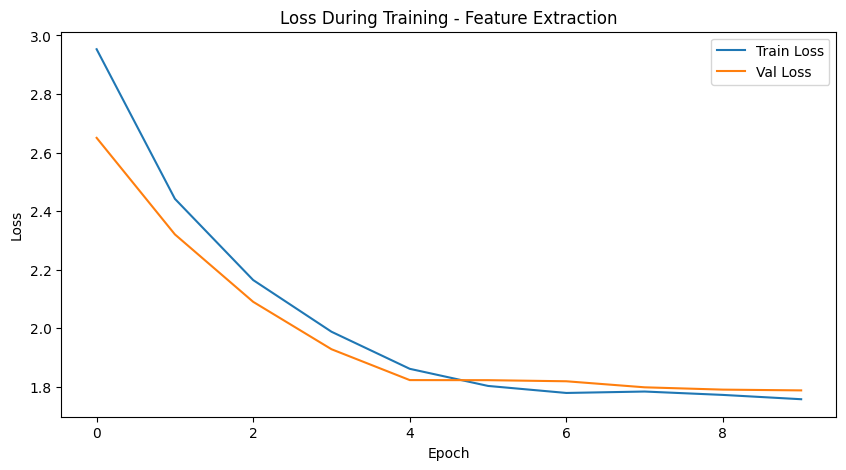

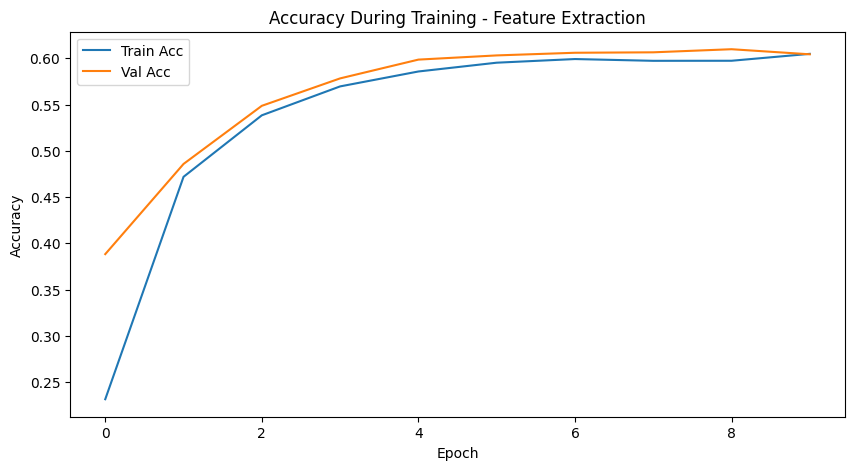

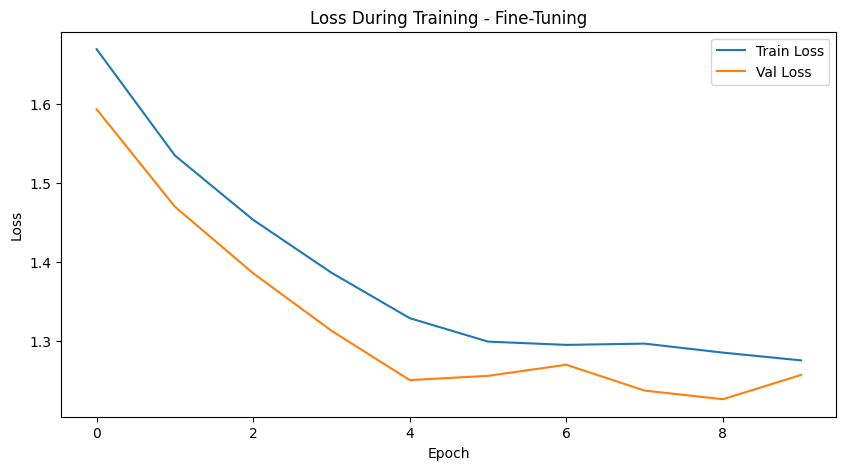

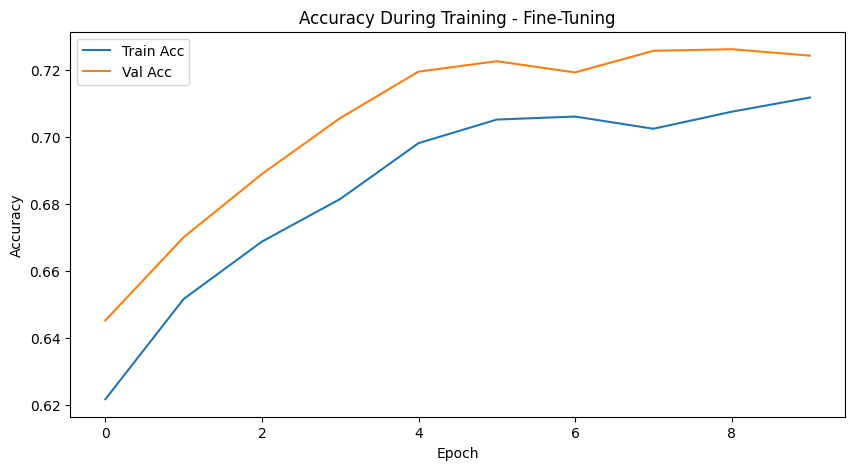

In [128]:
# График потерь для Feature Extraction
plt.figure(figsize=(10,5))
plt.title("Loss During Training - Feature Extraction")
plt.plot(history_fe['train_loss'], label='Train Loss')
plt.plot(history_fe['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# График точности для Feature Extraction
plt.figure(figsize=(10,5))
plt.title("Accuracy During Training - Feature Extraction")
plt.plot(history_fe['train_acc'], label='Train Acc')
plt.plot(history_fe['val_acc'], label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# То же самое для Fine-Tuning
plt.figure(figsize=(10,5))
plt.title("Loss During Training - Fine-Tuning")
plt.plot(history_ft['train_loss'], label='Train Loss')
plt.plot(history_ft['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Accuracy During Training - Fine-Tuning")
plt.plot(history_ft['train_acc'], label='Train Acc')
plt.plot(history_ft['val_acc'], label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


**Вывод по результатам проведённых экспериментов**  
В ходе выполнения заданий мы провели серию экспериментов по обучению модели для классификации персонажей из датасета «The Simpsons». Основной целью было изучение влияния различных методов обучения и настроек на качество модели. Ниже приведён подробный анализ наших действий, возникших проблем и полученных результатов.

1. **Использование различных LR Scheduler'ов**  
### *Эксперимент 1: StepLR*
  
Мы начали с загрузки датасета и модификации кода обучения, применив StepLR — шедулер, который уменьшает скорость обучения (learning rate) на заданный фактор каждые несколько эпох.

Настройки:
Оптимизатор: Adam с lr=0.001
Шедулер: StepLR с step_size=7 и gamma=0.1
Результаты:
Точность модели незначительно увеличивалась, но оставалась на уровне около 50%.  

### *Эксперимент 2: ReduceLROnPlateau*

Затем мы использовали ReduceLROnPlateau, который уменьшает learning rate, если метрика (в нашем случае — валидационная потеря) не улучшается в течение определённого количества эпох.

Настройки:
Оптимизатор: Adam с lr=0.001
Шедулер: ReduceLROnPlateau с factor=0.1 и patience=3
Результаты:
Точность всё ещё не повышалась значительно и держалась около 50%.  

2. **Подбор аугментаций для ухудшения качества модели**  
Мы попытались подобрать такие аугментации для тренировочных данных, которые значительно ухудшили бы качество модели на валидационном наборе.

*Применённые аугментации:*
Сильные повороты (RandomRotation до 90 градусов)
Размытие (GaussianBlur)
Сильные изменения цвета (ColorJitter с высокими параметрами)
Искажения перспективы и аффинные преобразования
Добавление шума (AddGaussianNoise)
Удаление частей изображения (RandomErasing)
Результаты:
Качество модели существенно снизилось, точность на валидационном наборе упала до ~40-45%.
Это показало, насколько агрессивные аугментации могут негативно повлиять на способность модели обобщать данные.

3. **Применение методов Feature Extraction и Fine-Tuning на архитектуре MobileNetV2**  
### Проблемы, с которыми мы столкнулись:

*Низкая точность модели (~50%):*

- Независимо от применяемых методов и настроек, точность модели не повышалась выше 50%.
- Это указывало на проблему в процессе обучения или подготовке данных.
  
*Ошибка в разделении данных:*  

- Мы обнаружили, что тренировочный и валидационный наборы данных загружались из одного и того же каталога без разделения.
- Это означало, что модель обучалась и валидировалась на одних и тех же данных, что приводило к неправильной оценке её качества.

  
### Решение проблемы:

*Корректное разделение данных:*

Мы использовали train_test_split для разделения индексов полного датасета на тренировочные и валидационные.
Создали пользовательский класс SubsetWithTransform для применения разных трансформаций к тренировочному и валидационному наборам данных.
Проверка структуры данных:

Обнаружили, что в class_to_idx присутствовал лишний класс 'simpsons_dataset', вызванный наличием одноимённой папки внутри основного каталога.
Удалили эту лишнюю папку, чтобы исключить неверные метки классов.
Применение методов:

*Feature Extraction:*

Использовали предобученную модель MobileNetV2.
Заморозили все слои модели и заменили последний классификатор на новый, соответствующий нашему числу классов.
Обучали только классификатор.
Fine-Tuning:

Разморозили последние два блока слоёв модели (features.16 и features.17).
Обучали модель с низкой скоростью обучения (lr=0.0001), чтобы донастроить её на нашем датасете.
Результаты после исправлений:

*Feature Extraction:*

Точность на тренировочном наборе достигла ~60%.
Точность на валидационном наборе также увеличилась до ~60%.
Потери (Loss) постепенно уменьшались с каждой эпохой.
Fine-Tuning:

Точность модели значительно улучшилась.
На 10-й эпохе точность на тренировочном наборе достигла ~71%, а на валидационном — ~72%.
Модель стала лучше обобщать данные и распознавать персонажей.  

4. **Выводы**
Основные выводы из проведённых экспериментов:

*Корректная подготовка данных является критически важной:*

Неправильное разделение данных на тренировочные и валидационные может привести к ошибочным результатам и затруднить обучение модели.
Важно убедиться, что тренировочные и валидационные наборы данных не пересекаются и имеют правильные метки классов.
Аугментации могут как улучшать, так и ухудшать качество модели:

Разумное использование аугментаций помогает модели обобщать данные и быть устойчивой к различным искажениям.
Слишком агрессивные аугментации могут привести к ухудшению качества модели, так как она будет обучаться на данных, сильно отличающихся от реальных.  

*Методы Feature Extraction и Fine-Tuning эффективны при правильном применении:*

Использование предобученных моделей позволяет значительно ускорить обучение и улучшить качество модели.
Замораживание слоёв и постепенное размораживание (Fine-Tuning) помогает модели адаптироваться к новым данным без переобучения.
Настройка гиперпараметров влияет на результаты:

Правильный выбор оптимизатора, скорости обучения и шедулера позволяет добиться лучшей сходимости и качества модели.
Эксперименты с различными настройками помогают найти оптимальные параметры для конкретной задачи.
  
*Рекомендации для будущих экспериментов:*  

*Увеличить количество эпох:*  
Обучение в течение большего числа эпох (20-30) может привести к ещё лучшим результатам.  
  
*Использовать более мощные модели:*  
Попробовать другие архитектуры, такие как ResNet или EfficientNet, для сравнения качества.  
  
*Балансировка данных:*  
Проверить, нет ли дисбаланса в количестве изображений разных классов, и при необходимости применить методы балансировки.  
  
*Мониторинг обучения:*  
Регулярно отслеживать метрики и визуализировать процесс обучения для своевременного обнаружения проблем.  
  
**Заключение**  
Проведённые эксперименты показали, насколько важно тщательно подходить к подготовке данных и настройке процесса обучения. Правильное разделение данных, использование подходящих аугментаций и методов обучения позволяют значительно улучшить качество модели и её способность обобщать данные. Методы Feature Extraction и Fine-Tuning, применённые к предобученной модели MobileNetV2, доказали свою эффективность в задаче классификации персонажей из «The Simpsons».